In [1]:
import torch
import torch.nn as nn
import torchvision.models as models

import glob
import tqdm
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import time
import tqdm 
import copy
from IPython.display import display, Image, clear_output
from tqdm import tqdm_notebook as tqdmn


In [2]:
camera_index = 0

cap = cv2.VideoCapture(camera_index, cv2.CAP_DSHOW) # this is the magic!


In [3]:

def plot_img(img,c='red'):
    # plt.imshow(img.transpose(1,0,2))
    cv2.imshow('a', cv2.cvtColor(img.transpose(1,0,2), cv2.COLOR_RGB2BGR))
    cv2.waitKey(1)

In [137]:

secondary_screen_width, secondary_screen_height = 800, 400 
scale = 1

pattern = np.zeros((secondary_screen_width//scale, secondary_screen_height//scale,3),dtype=np.uint8) 


jumps = 10

width = 2

In [138]:
800 * 400 // 100

3200

In [139]:
frames = []
clear_output()
pbar = tqdm.tqdm(total=(secondary_screen_width//scale//jumps)*(secondary_screen_height//scale//jumps), desc='Generating patterns')

for i in range(0,secondary_screen_width//scale,jumps):
    for j in range(0,secondary_screen_height//scale,jumps):
        pattern = np.zeros((secondary_screen_width//scale, secondary_screen_height//scale,3),dtype=np.uint8)
        pattern[i:i+width,:] = 255
        pattern[:,j:j+width] = 255
        plot_img(pattern)
        time.sleep(0.1)


        for k in range(5):
            ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
        else:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

        pbar.update(1)


Generating patterns:   6%|▌         | 47/800 [09:32<2:32:59, 12.19s/it]


Generating patterns: 100%|██████████| 3200/3200 [11:56<00:00,  4.41it/s]

In [140]:
pattern = np.zeros((secondary_screen_width//scale, secondary_screen_height//scale,3),dtype=np.uint8)
plot_img(pattern,'black')

for k in range(5):
    ret, frame = cap.read()
if not ret:
    print("Failed to grab frame")
else:
    base_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

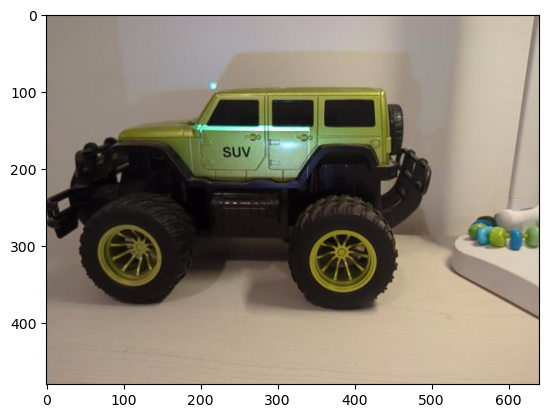

In [141]:
plt.imshow(base_frame)

In [142]:
base_frame = base_frame / 255.0


In [143]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image

def cross_point(d):
    img = (d.clip(0,1) * 255).astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = gray>80
    gray = gray.astype(np.uint8) * 100
    # Enhance contrast
    # gray = cv2.equalizeHist(gray)

    # Edge detection
    # edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Detect lines using Hough Transform
    lines = cv2.HoughLines(gray, 1, np.pi / 180, threshold=1)

    thr = 100
    lines_vert = []
    lines_horz = []

    while len(lines_vert) < 1 or len(lines_horz) < 1:
        lines = cv2.HoughLines(gray, 1, np.pi / 180, threshold=thr)
        if lines is not None:    
            for rho, theta in lines[:,0]:
                a = np.cos(theta)
                b = np.sin(theta)
                if abs(a) > abs(b):
                    lines_vert.append((rho,theta))
                else:
                    lines_horz.append((rho,theta))
        thr -= 5

        if thr < 30:
            return img, None


    # Convert polar coords to line equations and find intersection
    def get_line_params(rho, theta):
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        return pt1, pt2

    def line_intersection(p1, p2, p3, p4):
        """Return intersection point of lines (p1,p2) and (p3,p4)"""
        x1,y1 = p1
        x2,y2 = p2
        x3,y3 = p3
        x4,y4 = p4

        denom = (x1-x2)*(y3-y4) - (y1-y2)*(x3-x4)
        if denom == 0:
            return None  # parallel lines

        px = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4)) / denom
        py = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4)) / denom
        return int(px), int(py)

    # We'll store the first two lines only
    line_points = []

    rho, theta = lines_vert[0]
    p1, p2 = get_line_params(rho, theta)
    line_points.append((p1, p2))
    cv2.line(img, p1, p2, (0, 0, 255), 2)

    rho, theta = lines_horz[0]
    p1, p2 = get_line_params(rho, theta)
    line_points.append((p1, p2))
    cv2.line(img, p1, p2, (0, 0, 255), 2)
    pt = line_intersection(*line_points[0], *line_points[1])
    cv2.circle(img, pt, 7, (0, 255, 0), -1)
    
    return img, pt

In [144]:
clear_output()
clear_output()

f = 0
points = []
new_points = []
imgs = []
pbar = tqdm.tqdm(total=(secondary_screen_width//scale//jumps)*(secondary_screen_height//scale//jumps), desc='Finding cross points')
for i in range(0,secondary_screen_width//scale,jumps):
    for j in range(0,secondary_screen_height//scale,jumps):
        points.append((i,j))
        d = frames[f]/255.0-base_frame
        cp = cross_point(d)
        new_points.append(cp[1])
        imgs.append(cp[0])
        f+=1
        pbar.update(1)

Generating patterns: 100%|██████████| 3200/3200 [11:57<00:00,  4.46it/s]


In [145]:
positions = [(orig,n) for orig,n in zip(points,new_points) if n is not None]

original_points = np.array([x[0] for x in positions])
new_points = np.array([x[1] for x in positions])

H, _ = cv2.findHomography(original_points.astype(np.float64), new_points.astype(np.float64), cv2.RANSAC )


# Warp original points
warped_points_pred = cv2.perspectiveTransform(original_points.reshape(-1, 1, 2).astype(np.float64), H)


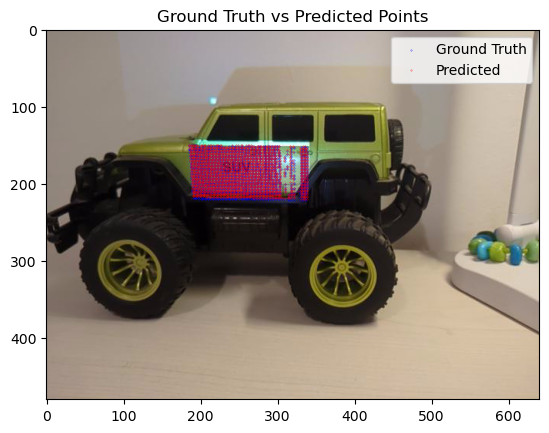

In [146]:
plt.imshow(base_frame)
plt.scatter(new_points[:, 0], new_points[:, 1], c='blue', label='Ground Truth', s=0.05)
# plt.scatter(new_points_sampled[:, 0], new_points_sampled[:, 1], c='blue', label='Ground Truth', s=0.05)
plt.scatter(warped_points_pred[:, 0, 0], warped_points_pred[:, 0, 1], c='red', label='Predicted', s=0.05)
plt.legend()
plt.title('Ground Truth vs Predicted Points')
plt.show()

In [152]:
import glob
# decoded_latents_path = glob.glob('current_pairs/adv_patch_*.jpg')
decoded_latents_path = glob.glob('botorch_snapshots//*patch*')


In [153]:
len(decoded_latents_path)

6375

In [149]:
import torchvision
resizer =  torchvision.transforms.Resize((400, 800))
tt = torchvision.transforms.ToTensor()


In [150]:
decoded_latents = []
for path in decoded_latents_path:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = img / 255.0
    decoded_latents.append(img)

In [154]:
frames = []
adv_patchs = []

for adv_patch in tqdm.tqdm_notebook(decoded_latents_path):

    if type(adv_patch) == str:
            adv_patch = cv2.imread(adv_patch)
            adv_patch = cv2.cvtColor(adv_patch, cv2.COLOR_BGR2RGB)
    # break
    adv_patch= (resizer(tt(adv_patch)).permute(1,2,0).numpy() * 255.0).astype(np.uint8)
    cv2.imshow('a',cv2.cvtColor(adv_patch, cv2.COLOR_RGB2BGR))
    cv2.waitKey(1)
    time.sleep(1)
    for ww in range(3):
        ret, frame = cap.read()
    if not ret:
        raise
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    if len(frames) != 0 and (frame != frames[-1]).sum() == 0:
        print('same frame')
        raise

    cv2.destroyAllWindows()

    frames.append(frame)
    adv_patchs.append(adv_patch)


C:\Users\danny\AppData\Local\Temp\ipykernel_7004\4145275471.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for adv_patch in tqdm.tqdm_notebook(decoded_latents_path):


  0%|          | 0/6375 [00:00<?, ?it/s]

In [85]:
cv2.destroyAllWindows()
time.sleep(3)
for k in range(5):
    ret, frame = cap.read()
if not ret:
    print("Failed to grab frame")
else:
    orig_ref_frame_for_saving = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    

In [86]:
import pickle
from torchvision import transforms
import matplotlib.pyplot as plt
tt = transforms.ToTensor()
# load data from calibration
# with open('./calibration_dump/calibration4.pickle','rb') as f:
#     H = pickle.load(f)
# with open('./calibration_dump/orig_ref_frame4.pickle','rb') as f:
#     orig_ref_frame = pickle.load(f)

from torchvision import transforms

tt = transforms.ToTensor()

import torch 
import kornia
H_t = torch.tensor(H).float().unsqueeze(0).cuda()
def warp(img):
    return kornia.geometry.transform.warp_perspective(img, H_t, (orig_ref_frame_for_saving.shape[0], orig_ref_frame_for_saving.shape[1]))


H_t_i = H_t.inverse()
def unwarp(img):
    return kornia.geometry.transform.warp_perspective(img, H_t_i , (400,800))

In [155]:
unwrapped_frames = []
with torch.no_grad():
    for frame in tqdm.tqdm_notebook(frames):
        frame_tensor = torch.tensor(frame).permute(2,0,1).float().cuda().unsqueeze(0) / 255
        unwrapped_frame = unwarp(frame_tensor).squeeze(0).cpu()
        unwrapped_frames.append(unwrapped_frame)

for i in tqdm.tqdm_notebook(range(len(unwrapped_frames))):
    unwrapped_frame = unwrapped_frames[i].cpu().numpy().transpose(1,2,0)
    unwrapped_frame = (unwrapped_frame * 255).astype(np.uint8)
    unwrapped_frame = cv2.cvtColor(unwrapped_frame, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f'botorch_snapshots//unwrapped_frame_20_4_{i}.jpg',unwrapped_frame)

C:\Users\danny\AppData\Local\Temp\ipykernel_7004\3903645692.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for frame in tqdm.tqdm_notebook(frames):


  0%|          | 0/6375 [00:00<?, ?it/s]

C:\Users\danny\AppData\Local\Temp\ipykernel_7004\3903645692.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(len(unwrapped_frames))):


  0%|          | 0/6375 [00:00<?, ?it/s]

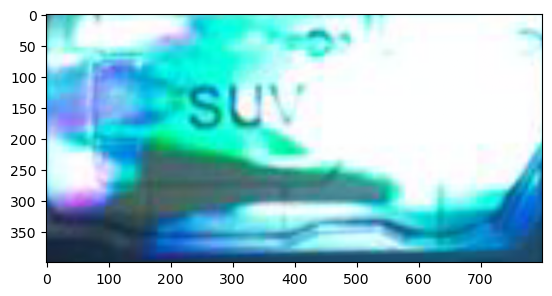

In [104]:
plt.imshow(unwarp(tt(frames[244]).unsqueeze(0).cuda()).cpu().permute(0,2,3,1).squeeze(0).numpy())

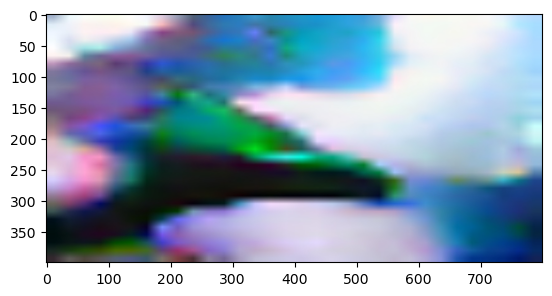

In [105]:
plt.imshow(adv_patchs[244])

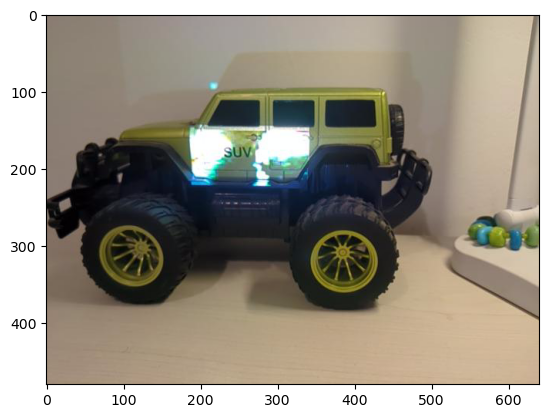

In [94]:
plt.imshow(frames[1])